Note: Please mention your Python version (and maybe the version of all other packages).
In this exercise, you are going to run some experiments involving CNNs. You need to know Python and install
the following libraries: Pytorch, matplotlib and all their dependencies. You can find detailed instructions and
tutorials for each of these libraries on the respective websites.
For all experiments, running on the CPU is sufficient. You do not need to run the code on GPUs. Before
starting, we suggest you review what we learned about each layer in CNN, and read at least this tutorial.

In [9]:
!nvidia-smi

Fri Mar 22 15:02:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              30W /  70W |    899MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import pandas as pd
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import random_split


1. (17 pts) Implement and train a VGG11 net on the complete MNIST dataset. VGG11 was an earlier
version of VGG16 and can be found as model A in Table 1 of this paper, whose Section 2.1 also gives you
all the details about each layer. The goal is to get the loss as close to 0 as possible. Note that our input
dimension is different from the VGG paper. You need to resize each image in MNIST from its original
size 28 × 28 to 32 × 32 [why?].
For your convenience, we list the details of the VGG11 architecture here. The convolutional layers
are denoted as Conv(number of input channels, number of output channels, kernel size, stride, padding); the batch normalization layers are denoted as BatchNorm(number of channels);
the max-pooling layers are denoted as MaxPool(kernel size, stride); the fully-connected layers are
denoted as Linear(number of input features, number of output features); the drop out layers
are denoted as Dropout(dropout ratio):


You should use the following in your training process unless specified otherwise: cross-entropy loss
torch.nn.CrossEntropyLoss, and optimize using SGD optimizer with momentum=0.9.
[This experiment will take up to 1 hour on a CPU, so please be cautious of your time. If this running
time is not bearable, you may cut the training set to 1/10, so only have ∼600 images per class instead
of the regular ∼6000.]

In [11]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.RandomGrayscale(), ##not sure
                                transforms.Normalize((0.5,), (0.5,))])

# Load MNIST dataset
full_train_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
full_test_data = datasets.MNIST('~/.pytorch/MNIST_data/', train=False, download=True, transform=transform)

train_loader = DataLoader(full_train_data, batch_size = 64, shuffle = True)
test_loader = DataLoader(full_test_data, batch_size = 64, shuffle = False)


In [13]:
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x




In [14]:
model = VGG11().cuda()

# Define the loss function and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

if torch.cuda.is_available():
   model = model.cuda()

train_acc_values = []
train_loss_values = []
test_acc_values = []
test_loss_values = []
num_epoch = 20
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    test_acc = 0.0
    test_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):

        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            test_pred = model(data[0].cuda())
            batch_loss = loss(test_pred, data[1].cuda())

            test_acc += np.sum(np.argmax(test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            test_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Test Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/full_train_data.__len__(), train_loss/full_train_data.__len__(), test_acc/full_test_data.__len__(), test_loss/full_test_data.__len__()))

    train_acc_values.append(train_acc/full_train_data.__len__())
    train_loss_values.append(train_loss/full_train_data.__len__())
    test_acc_values.append(test_acc/full_test_data.__len__())
    test_loss_values.append(test_loss/full_test_data.__len__())


[001/020] 41.08 sec(s) Train Acc: 0.960300 Loss: 0.002004 | Test Acc: 0.982500 loss: 0.000946
[002/020] 42.16 sec(s) Train Acc: 0.989517 Loss: 0.000561 | Test Acc: 0.992600 loss: 0.000385
[003/020] 52.74 sec(s) Train Acc: 0.992250 Loss: 0.000418 | Test Acc: 0.993200 loss: 0.000342
[004/020] 47.63 sec(s) Train Acc: 0.994633 Loss: 0.000296 | Test Acc: 0.994500 loss: 0.000280
[005/020] 49.21 sec(s) Train Acc: 0.995417 Loss: 0.000243 | Test Acc: 0.994500 loss: 0.000304
[006/020] 43.95 sec(s) Train Acc: 0.996767 Loss: 0.000186 | Test Acc: 0.993300 loss: 0.000341
[007/020] 46.55 sec(s) Train Acc: 0.997183 Loss: 0.000149 | Test Acc: 0.993900 loss: 0.000339
[008/020] 44.57 sec(s) Train Acc: 0.997583 Loss: 0.000122 | Test Acc: 0.994400 loss: 0.000353
[009/020] 48.57 sec(s) Train Acc: 0.997750 Loss: 0.000117 | Test Acc: 0.993900 loss: 0.000356
[010/020] 45.17 sec(s) Train Acc: 0.998633 Loss: 0.000077 | Test Acc: 0.995100 loss: 0.000344
[011/020] 47.57 sec(s) Train Acc: 0.998567 Loss: 0.000076 | 

2. (3 pts) Once you’ve done the above, the next goal is to inspect the training process. Create the following
plots:
(a) test accuracy vs the number of epochs
(b) training accuracy vs the number of epochs
(c) test loss vs the number of epochs
(d) training loss vs the number of epochs
[If timing is an issue, train the neural networks for 20 epochs. Although 20 epochs are not sufficient to
reach convergence, it is sufficient to see the trend. You can reduce the number of epochs further if it is
infeasible to train for 20 epochs.]

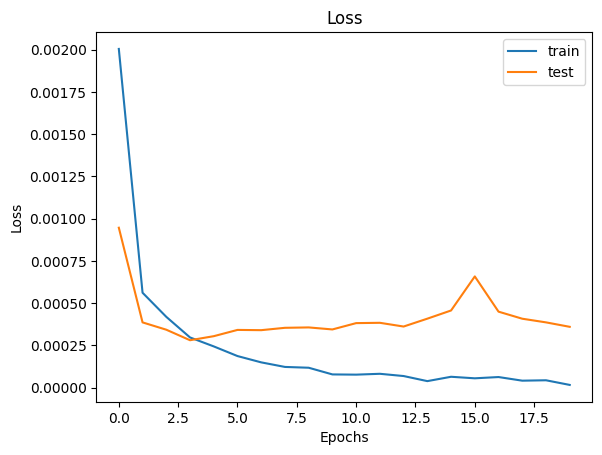

In [15]:
plt.plot(train_loss_values)
plt.plot(test_loss_values)
plt.title('Loss')
plt.legend(['train','test'])
plt.savefig('loss_SGD.png')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

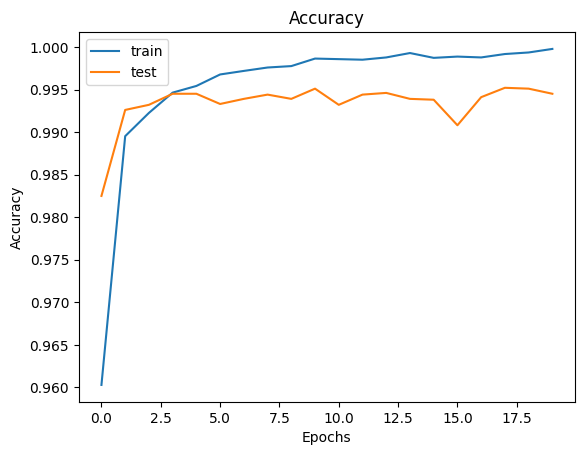

In [16]:
plt.plot(train_acc_values)
plt.plot(test_acc_values)
plt.title('Accuracy')
plt.legend(['train','test'])
plt.savefig('acc_SGD.png')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

3. (10 pts) Train your CNN with Adam. Plot the graphs for training and test accuracies vs the number of
epochs for Adam. Compare the accuracies of Adam with the SGD accuracies in Ex 1.2. Which optimizer
performed better and why?

In [17]:
model = VGG11()

# Define the loss function and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_acc_val_Adam = []
train_loss_val_Adam = []
test_acc_val_Adam = []
test_loss_val_Adam = []

num_epoch = 20

if torch.cuda.is_available():
   model = model.cuda()

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    test_acc = 0.0
    test_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):

        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            test_pred = model(data[0].cuda())
            batch_loss = loss(test_pred, data[1].cuda())

            test_acc += np.sum(np.argmax(test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            test_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Test Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/full_train_data.__len__(), train_loss/full_train_data.__len__(), test_acc/full_test_data.__len__(), test_loss/full_test_data.__len__()))

    train_acc_val_Adam.append(train_acc/full_train_data.__len__())
    train_loss_val_Adam.append(train_loss/full_train_data.__len__())
    test_acc_val_Adam.append(test_acc/full_test_data.__len__())
    test_loss_val_Adam.append(test_loss/full_test_data.__len__())

[001/020] 47.00 sec(s) Train Acc: 0.863583 Loss: 0.006125 | Test Acc: 0.982900 loss: 0.001099
[002/020] 45.97 sec(s) Train Acc: 0.977750 Loss: 0.001625 | Test Acc: 0.987300 loss: 0.001008
[003/020] 45.74 sec(s) Train Acc: 0.982000 Loss: 0.001419 | Test Acc: 0.984500 loss: 0.001204
[004/020] 45.69 sec(s) Train Acc: 0.986617 Loss: 0.001008 | Test Acc: 0.992200 loss: 0.000645
[005/020] 45.50 sec(s) Train Acc: 0.987717 Loss: 0.000890 | Test Acc: 0.992700 loss: 0.000475
[006/020] 46.02 sec(s) Train Acc: 0.990083 Loss: 0.000684 | Test Acc: 0.989000 loss: 0.001230
[007/020] 45.87 sec(s) Train Acc: 0.986983 Loss: 0.001130 | Test Acc: 0.992600 loss: 0.000465
[008/020] 45.82 sec(s) Train Acc: 0.992683 Loss: 0.000517 | Test Acc: 0.991600 loss: 0.000913
[009/020] 44.93 sec(s) Train Acc: 0.993717 Loss: 0.000426 | Test Acc: 0.993100 loss: 0.000452
[010/020] 45.68 sec(s) Train Acc: 0.991683 Loss: 0.000693 | Test Acc: 0.993700 loss: 0.000478
[011/020] 46.14 sec(s) Train Acc: 0.995000 Loss: 0.000331 | 

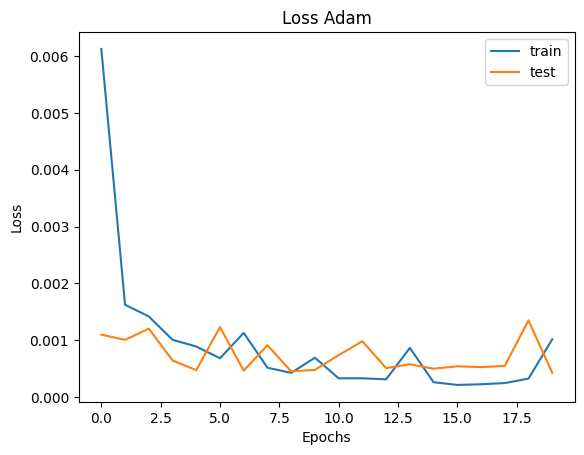

In [18]:
plt.plot(train_loss_val_Adam)
plt.plot(test_loss_val_Adam)
plt.title('Loss Adam')
plt.legend(['train','test'])
plt.savefig('loss_adam.png')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

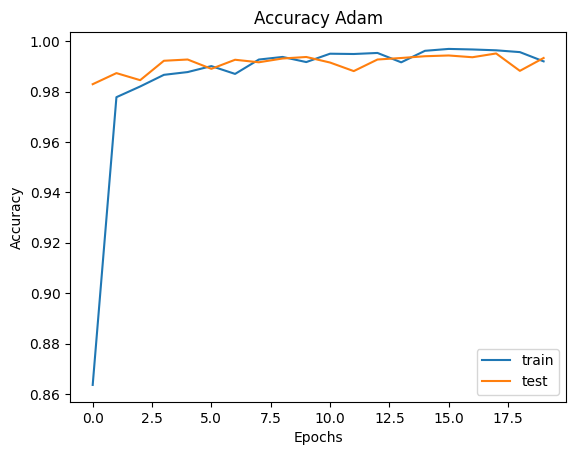

In [19]:
plt.plot(train_acc_val_Adam)
plt.plot(test_acc_val_Adam)
plt.title('Accuracy Adam')
plt.legend(['train','test'])
plt.savefig('acc_adam.png')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

4. (10 pts) Replace ReLU activation with Sigmoid in your CNN and train it again. Plot the graphs for
training and test accuracies vs the number of epochs. Compare it with your results in Ex 2.2. Do you
see any change because of Sigmoid? If so, explain why.

In [20]:
class VGG11_sig(nn.Module):
    def __init__(self):
        super(VGG11_sig, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2, 0),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [21]:
model = VGG11_sig()

# Define the loss function and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_acc_val_sig = []
train_loss_val_sig = []
test_acc_val_sig = []
test_loss_val_sig = []

num_epoch = 20

if torch.cuda.is_available():
   model = model.cuda()


for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    test_acc = 0.0
    test_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):

        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            test_pred = model(data[0].cuda())
            batch_loss = loss(test_pred, data[1].cuda())

            test_acc += np.sum(np.argmax(test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            test_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Test Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/full_train_data.__len__(), train_loss/full_train_data.__len__(), test_acc/full_test_data.__len__(), test_loss/full_test_data.__len__()))

    train_acc_val_sig.append(train_acc/full_train_data.__len__())
    train_loss_val_sig.append(train_loss/full_train_data.__len__())
    test_acc_val_sig.append(test_acc/full_test_data.__len__())
    test_loss_val_sig.append(test_loss/full_test_data.__len__())

[001/020] 41.64 sec(s) Train Acc: 0.431700 Loss: 0.024819 | Test Acc: 0.277900 loss: 0.105784
[002/020] 42.49 sec(s) Train Acc: 0.935183 Loss: 0.003725 | Test Acc: 0.620000 loss: 0.021477
[003/020] 41.21 sec(s) Train Acc: 0.968583 Loss: 0.001833 | Test Acc: 0.644500 loss: 0.018894
[004/020] 42.38 sec(s) Train Acc: 0.977650 Loss: 0.001303 | Test Acc: 0.911500 loss: 0.004943
[005/020] 41.40 sec(s) Train Acc: 0.982933 Loss: 0.000976 | Test Acc: 0.937300 loss: 0.003413
[006/020] 41.71 sec(s) Train Acc: 0.985833 Loss: 0.000808 | Test Acc: 0.977600 loss: 0.001303
[007/020] 41.70 sec(s) Train Acc: 0.988667 Loss: 0.000649 | Test Acc: 0.803400 loss: 0.009553
[008/020] 41.83 sec(s) Train Acc: 0.990017 Loss: 0.000578 | Test Acc: 0.986800 loss: 0.000908
[009/020] 42.11 sec(s) Train Acc: 0.991650 Loss: 0.000454 | Test Acc: 0.983200 loss: 0.001098
[010/020] 42.14 sec(s) Train Acc: 0.992917 Loss: 0.000378 | Test Acc: 0.828400 loss: 0.010653
[011/020] 42.93 sec(s) Train Acc: 0.993867 Loss: 0.000331 | 

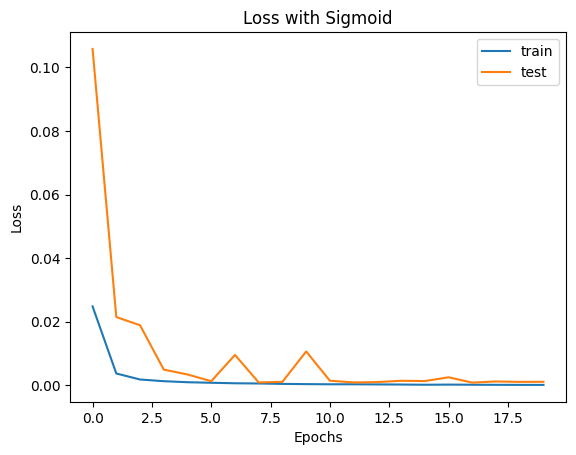

In [22]:
plt.plot(train_loss_val_sig)
plt.plot(test_loss_val_sig)
plt.title('Loss with Sigmoid')
plt.legend(['train','test'])
plt.savefig('loss_sig.png')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

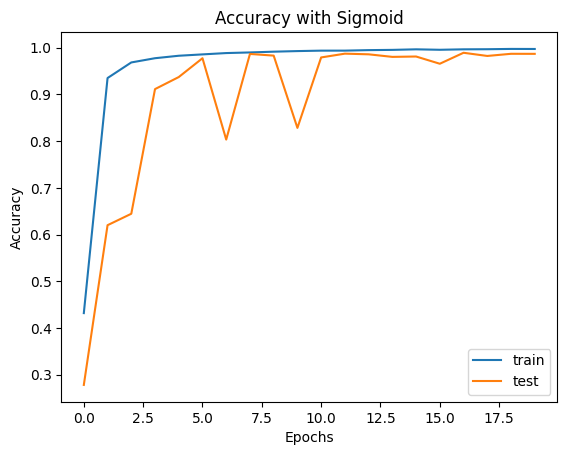

In [23]:
plt.plot(train_acc_val_sig)
plt.plot(test_acc_val_sig)
plt.title('Accuracy with Sigmoid')
plt.legend(['train','test'])
plt.savefig('acc_sig.png')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

5. (10 pts) Remove Dropout from your CNN and train it again. Plot the graphs for training and test
accuracies vs the number of epochs. Compare it with your results in Ex 2.2. Did Dropout have any effect
on your network performance? Explain.

In [24]:
class VGG11_drop(nn.Module):
    def __init__(self):
        super(VGG11_drop, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2, 0),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.Sigmoid(),
            nn.Linear(4096, 4096),
            nn.Sigmoid(),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [25]:
model = VGG11_drop()

# Define the loss function and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_acc_val_drop = []
train_loss_val_drop = []
test_acc_val_drop = []
test_loss_val_drop = []

num_epoch = 20

if torch.cuda.is_available():
   model = model.cuda()


for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    test_acc = 0.0
    test_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):

        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            test_pred = model(data[0].cuda())
            batch_loss = loss(test_pred, data[1].cuda())

            test_acc += np.sum(np.argmax(test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            test_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Test Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/full_train_data.__len__(), train_loss/full_train_data.__len__(), test_acc/full_test_data.__len__(), test_loss/full_test_data.__len__()))

    train_acc_val_drop.append(train_acc/full_train_data.__len__())
    train_loss_val_drop.append(train_loss/full_train_data.__len__())
    test_acc_val_drop.append(test_acc/full_test_data.__len__())
    test_loss_val_drop.append(test_loss/full_test_data.__len__())

[001/020] 41.53 sec(s) Train Acc: 0.355183 Loss: 0.026623 | Test Acc: 0.255800 loss: 0.034526
[002/020] 42.00 sec(s) Train Acc: 0.894200 Loss: 0.005887 | Test Acc: 0.885100 loss: 0.006313
[003/020] 42.01 sec(s) Train Acc: 0.954983 Loss: 0.003006 | Test Acc: 0.914800 loss: 0.004971
[004/020] 42.09 sec(s) Train Acc: 0.970817 Loss: 0.002067 | Test Acc: 0.962100 loss: 0.002878
[005/020] 41.41 sec(s) Train Acc: 0.977617 Loss: 0.001613 | Test Acc: 0.866100 loss: 0.008429
[006/020] 41.45 sec(s) Train Acc: 0.981783 Loss: 0.001239 | Test Acc: 0.973200 loss: 0.002003
[007/020] 40.96 sec(s) Train Acc: 0.985533 Loss: 0.000976 | Test Acc: 0.975500 loss: 0.001759
[008/020] 41.54 sec(s) Train Acc: 0.987667 Loss: 0.000790 | Test Acc: 0.836900 loss: 0.008884
[009/020] 40.88 sec(s) Train Acc: 0.988167 Loss: 0.000749 | Test Acc: 0.949900 loss: 0.003983
[010/020] 41.73 sec(s) Train Acc: 0.990450 Loss: 0.000654 | Test Acc: 0.982200 loss: 0.001653
[011/020] 40.98 sec(s) Train Acc: 0.992033 Loss: 0.000500 | 

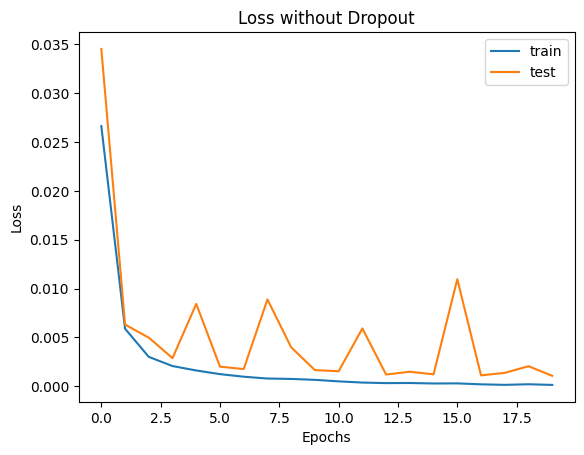

In [26]:
plt.plot(train_loss_val_drop)
plt.plot(test_loss_val_drop)
plt.title('Loss without Dropout')
plt.legend(['train','test'])
plt.savefig('loss_drop.png')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

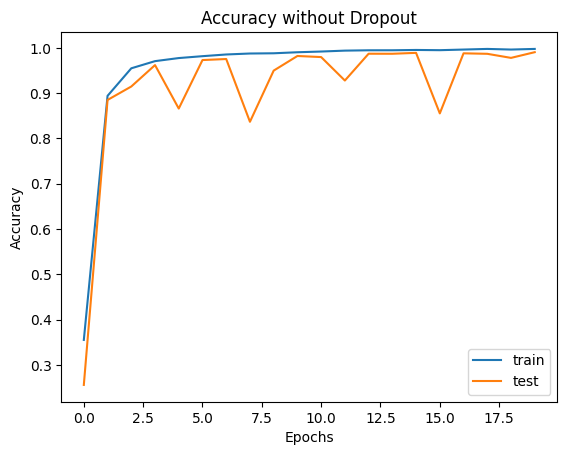

In [27]:
plt.plot(train_acc_val_drop)
plt.plot(test_acc_val_drop)
plt.title('Accuracy without Dropout')
plt.legend(['train','test'])
plt.savefig('acc_drop.png')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()